In [1]:
!pip install datasets
!pip install sentence-transformers

# 1. Imports & Setup

In [2]:
# Data Manipulation
import numpy as np
import pandas as pd
from datasets import load_dataset  # Hugging Face Datasets

# Visualization
import matplotlib.pyplot as plt

# Machine Learning (Scikit-Learn)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Deep Learning / NLP
from sentence_transformers import SentenceTransformer

# 2. Data Preparation

In [3]:
# Load the 'sms_spam' dataset from Hugging Face Hub
dataset = load_dataset("sms_spam")
df = pd.DataFrame(dataset['train'])

# Split the dataset into Training (80%) and Test (20%) sets
# random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    df['sms'], df['label'], test_size=0.2, random_state=42
)

# Display dataset statistics
print(f"Total samples: {len(df)}")
print(f"Training set size: {len(X_train)}")
print(f"Test set size:     {len(X_test)}")

Total samples: 5574
Training set size: 4459
Test set size:     1115


# 3. Naïve Baseline

In [4]:
# Purpose: Identify keywords that appear frequently in Spam but rarely in Ham.
# We use CountVectorizer to count word occurrences in the training set.
vec = CountVectorizer(stop_words='english')
X_train_vec = vec.fit_transform(X_train)
all_words = vec.get_feature_names_out()

# Calculate total frequency for each word in Spam vs. Ham messages
spam_counts = X_train_vec[y_train.values == 1].sum(axis=0)
ham_counts = X_train_vec[y_train.values == 0].sum(axis=0)

# Calculate score: (Frequency in Spam) - (Frequency in Ham)
# High positive score indicates a strong indicator of Spam.
score = np.array(spam_counts).flatten() - np.array(ham_counts).flatten()

# Extract top 10 discriminative keywords
top_n = 10
top_indices = score.argsort()[::-1][:top_n]
keywords = [all_words[i] for i in top_indices]

print(f"Top {top_n} spam keywords:")
print(keywords)

Top 10 spam keywords:
['free', 'txt', 'claim', 'mobile', 'www', 'stop', 'prize', '150p', 'cash', 'uk']


In [5]:
# Define the baseline detection function
def data_driven_detector(text):
    text = str(text).lower()
    # Simple Rule: If any extracted keyword exists, classify as Spam (1)
    for word in keywords:
        if word in text:
            return 1 
    return 0 # Otherwise, classify as Ham (0)

# Run baseline predictions on the test set
y_pred_baseline = [data_driven_detector(text) for text in X_test]

# 4. AI Pipeline (Embeddings + Classifier)

In [6]:
# Load Pre-trained Model
# We use 'all-MiniLM-L6-v2' for its balance of speed and semantic understanding.
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encoding (Feature Extraction)
# Convert raw text into fixed-size 384-dimensional dense vectors.
X_train_emb = model.encode(X_train.tolist(), show_progress_bar=True)
X_test_emb = model.encode(X_test.tolist(), show_progress_bar=True)

# Train Classifier
# Train a Logistic Regression classifier on the generated embeddings.
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_emb, y_train)

# Inference
y_pred_ai = classifier.predict(X_test_emb)

Batches:   0%|          | 0/140 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

# 5. Evaluation & Visualization

In [7]:
target_names = ['Ham', 'Spam']

# Print Classification Reports
print("Naïve Baseline Performance:")
print(classification_report(y_test, y_pred_baseline, target_names=target_names))

print("-" * 50)

print("AI Pipeline Performance:")
print(classification_report(y_test, y_pred_ai, target_names=target_names))

Naïve Baseline Performance:
              precision    recall  f1-score   support

         Ham       0.97      0.96      0.97       954
        Spam       0.79      0.81      0.80       161

    accuracy                           0.94      1115
   macro avg       0.88      0.89      0.88      1115
weighted avg       0.94      0.94      0.94      1115

--------------------------------------------------
AI Pipeline Performance:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       954
        Spam       1.00      0.91      0.95       161

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [8]:
# Prepare Data for Plotting
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    # Extract Precision, Recall, and F1 specifically for the 'Spam' class (binary average)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return [acc, prec, rec, f1]

baseline_scores = get_metrics(y_test, y_pred_baseline)
ai_scores = get_metrics(y_test, y_pred_ai)

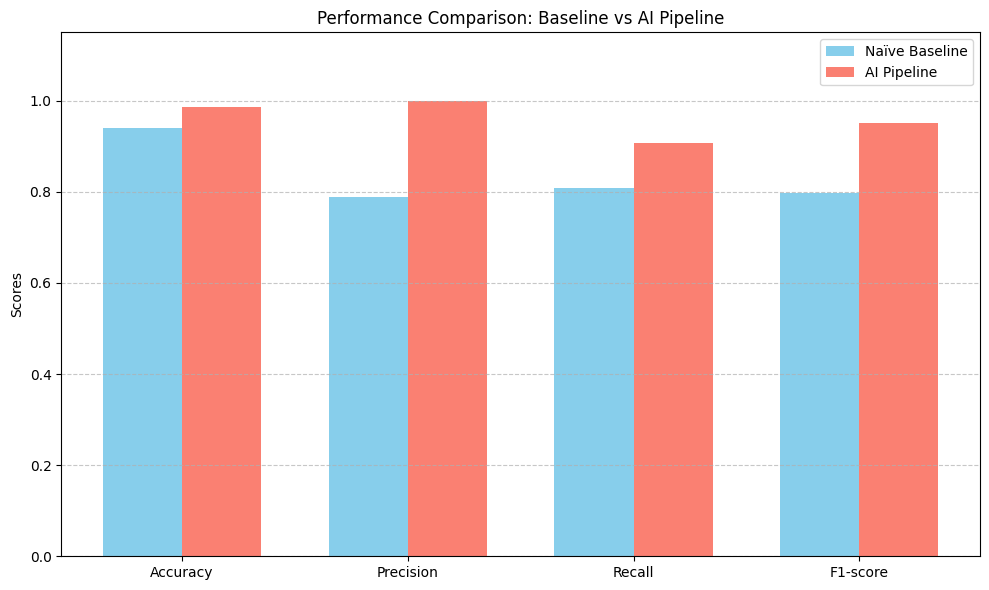

In [9]:
# Plot Grouped Bar Chart
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, baseline_scores, width, label='Naïve Baseline', color='skyblue')
rects2 = ax.bar(x + width/2, ai_scores, width, label='AI Pipeline', color='salmon')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison: Baseline vs AI Pipeline')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.15) # Add space for labels
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300) # Save figure
plt.show()

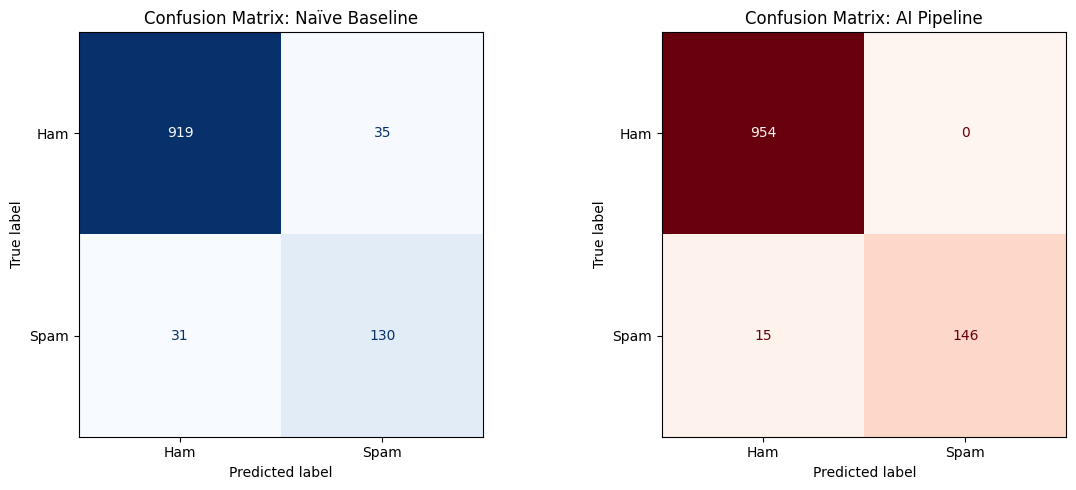

In [10]:
# Plot Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Baseline Matrix
cm_base = confusion_matrix(y_test, y_pred_baseline)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=['Ham', 'Spam'])
disp_base.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('Confusion Matrix: Naïve Baseline')

# AI Pipeline Matrix
cm_ai = confusion_matrix(y_test, y_pred_ai)
disp_ai = ConfusionMatrixDisplay(confusion_matrix=cm_ai, display_labels=['Ham', 'Spam'])
disp_ai.plot(ax=ax2, cmap='Reds', colorbar=False)
ax2.set_title('Confusion Matrix: AI Pipeline')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300) # Save figure
plt.show()

# 6. Qualitative Analysis

In [11]:
label_map = {0: "Ham", 1: "Spam"}
count = 0

# Find examples where Baseline failed but AI succeeded
for text, true_val, base_pred, ai_pred in zip(X_test, y_test, y_pred_baseline, y_pred_ai):
    if base_pred != true_val and ai_pred == true_val:
        print(f"--- Example Case {count + 1} ---")
        print(f"Text: \"{text}\"")
        print(f"Actual Label: {label_map[true_val]}")
        print(f"Baseline Pred: {label_map[base_pred]}")
        print(f"AI Pred      : {label_map[ai_pred]}")
        print("--------------------------------------------------\n")
        
        count += 1
        if count >= 3: 
            break

--- Example Case 1 ---
Text: "K, wen ur free come to my home and also tel vikky i hav sent mail to him also.. Better come evening il be free today aftr 6pm..:-)
"
Actual Label: Ham
Baseline Pred: Spam
AI Pred      : Ham
--------------------------------------------------

--- Example Case 2 ---
Text: "Call Germany for only 1 pence per minute! Call from a fixed line via access number 0844 861 85 85. No prepayment. Direct access!
"
Actual Label: Spam
Baseline Pred: Ham
AI Pred      : Spam
--------------------------------------------------

--- Example Case 3 ---
Text: "Dear,shall mail tonite.busy in the street,shall update you tonite.things are looking ok.varunnathu edukkukayee raksha ollu.but a good one in real sense.
"
Actual Label: Ham
Baseline Pred: Spam
AI Pred      : Ham
--------------------------------------------------

